# Regression Week 4: Ass2:  Ridge Regression (gradient descent)

In this notebook, you will implement ridge regression via gradient descent. You will:
* Convert an SFrame into a Numpy array
* Write a Numpy function to compute the derivative of the regression weights with respect to a single feature
* Write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

# Fire up graphlab create

Make sure you have the latest version of GraphLab Create (>= 1.7)

In [81]:
import pandas as pd

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

**1.** If you’re using SFrame, import GraphLab Create and load in the house data as follows:

In [82]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':str, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

# if using Pandas
sales = pd.read_csv('../Week3/kc_house_data.csv', dtype = dtype_dict)

**2.** If you’re using Python: to do the matrix operations required to perform a gradient descent we will be using the popular python library ‘numpy’ which is a computational library specialized for operations on arrays. 

In [83]:
# import pandas as pd
import numpy as np # note this allows us to refer to numpy as np instead 

If we want to do any "feature engineering" like creating new features or adjusting existing ones we should do this directly using the SFrames as seen in the first notebook of Week 2. For this notebook, however, we will work with the existing features.

# Import useful functions from previous notebook

**3.** Next, from Module 2, copy and paste the ‘get_numpy_data’ function (or equivalent) that takes a dataframe, a list of features (e.g. [‘sqft_living’, ‘bedrooms’]), to be used as inputs, and a name of the output (e.g. ‘price’). This function returns a ‘feature_matrix’ (2D array) consisting of first a column of ones followed by columns containing the values of the input features in the data set in the same order as the input list. It alsos return an ‘output_array’ which is an array of the values of the output in the data set (e.g. ‘price’).
As in Week 2, we convert the SFrame into a 2D Numpy array. Copy and paste `get_numpy_data()` from the second notebook of Week 2.

In [84]:
# inputs
# a dataframe, a list of features (e.g. [‘sqft_living’, ‘bedrooms’]), and name of the output (e.g. ‘price’)
# ouputs
#  ‘feature_matrix’ (2D array)
#  an ‘output_array’ which is an array of the values of the output in the data set (e.g. ‘price’)

# Call like this, collecting return data in a tuple
# (example_features, example_output) =  get_numpy_data(sales, ['sqft_living'], 'price')
# NB., sales is the pdFrame, features_list = ['sqft_living', ....], response = 'price')
    
def get_numpy_data(data_pdframe, features, output):
    
    data_pdframe['constant'] = 1 # this is how you add a new column to an dataframe
    
    # add the column 'constant' to the FRONT of the features list 
    # so that we can extract it along with the others:
    features = ['constant'] + features # add two lists
    
    #NB features = 'constant' + features  wont work!! - can't add string constant to a list
    
    print "get_numpy_data(): Features", features, "\n"  
    
    # select the columns of data_pdFrame given by the features list 
    # into the pdFrame features_pdframe (now including constant 1 col):
    features_pdframe = data_pdframe[features]
    
    print "get_numpy_data(): print features_pdframe(head(2)\n",features_pdframe.head(2), "\n"  
    #prints the 2 columns n its values, constant and sqft_living
    
    # Convert the pdframe to its Numpy-array representation.
    # feature_matrix = features_sframe.to_numpy()    #if sframe , use .to_numpy()
    feature_matrix = features_pdframe.as_matrix()    #if pdframe ,use .as_matrix() 
    len(feature_matrix)
    print "get_numpy_data(): print features_pdframe.as_matrix()[0:2, :]\n",feature_matrix[0:2, :] , "\n" 
    
    # assign the column of data_pdframe associated with the output to the SArray output_sarray
    output_sarray = data_pdframe[output]
    print "get_numpy_data(): data_pdframe['price']\n", output_sarray.head(2), "\n"
    
    # Convert the pdframe column - a series to its Numpy-array representation.
    # output_array = output_sarray.to_numpy()   #if column is sframe column  i.e a sarray
    output_array = output_sarray.as_matrix()    #if column is pdframe column i.e a series
    print "get_numpy_data(): data_pdframe['price'].as_matrix()\n", output_array[0:2], "\n"
    
    return(feature_matrix, output_array)

**4.** Similarly, copy and paste the `predict_output()` function to compute the predictions for an entire matrix of features given the matrix and the weights: This function accepts a 2D array ‘feature_matrix’ and a 1D array ‘weights’ and return a 1D array ‘predictions’.

In [85]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns 
    # and weights is a corresponding numpy array (our list of model coefficients)
    # create the predictions vector by using np.dot()
    
    predictions = np.dot(feature_matrix, weights)
    
    return(predictions)

# Computing the Derivative

**5.** We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Week 2 and add the derivative of the regularization part.  As we saw, the derivative of the RSS with respect to `w[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `w[i]` is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

**We will not regularize the constant.**  Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the `2*l2_penalty*w[0]` term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus `2*l2_penalty*w[i]`.

**6.** With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).  To decide when we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call `feature_is_constant` which you should set to `True` when computing the derivative of the constant and `False` otherwise.

In [86]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # Assume that errors and feature are both numpy arrays of the same length (number of data points)

    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    if feature_is_constant is True:
        derivative = 2 * np.dot(errors,feature)
    else:
        derivative = 2 * np.dot(errors,feature) + 2 * l2_penalty * weight
    
    
    return derivative

**7.**To test your feature derivartive run the following:

In [87]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False)
print np.sum(errors*example_features[:,1])*2+20.
print ''

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True)
print np.sum(errors)*2.

get_numpy_data(): Features ['constant', 'sqft_living'] 

get_numpy_data(): print features_pdframe(head(2)
   constant  sqft_living
0         1       1180.0
1         1       2570.0 

get_numpy_data(): print features_pdframe.as_matrix()[0:2, :]
[[  1.00000000e+00   1.18000000e+03]
 [  1.00000000e+00   2.57000000e+03]] 

get_numpy_data(): data_pdframe['price']
0    221900.0
1    538000.0
Name: price, dtype: float64 

get_numpy_data(): data_pdframe['price'].as_matrix()
[ 221900.  538000.] 

-5.6554166816e+13
-5.6554166816e+13

-22446749330.0
-22446749330.0


# Gradient Descent

**8.**Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a **maximum number of iterations** and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria. The function will take the following parameters:
* 2D feature matrix
* array of output values
* initial weights
* step size
* L2 penalty
* maximum number of iterations



In [88]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, 
                                      step_size, l2_penalty, max_iterations=100):
    weights = np.array(initial_weights) # make sure it's a numpy array
    
    #while not reached maximum number of iterations:
    count = 0
    while(count < max_iterations):
        count += 1
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        errors = predictions - output
    

        for i in xrange(len(weights)): # loop over each weight
            
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if i is 0:
                is_con = True
            else:
                is_con = False
             
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            
            feature = feature_matrix[: ,i] 
            weight = weights[i]
            derivative = feature_derivative_ridge(errors, feature, weight, l2_penalty, is_con)
            
            # subtract the step size times the derivative from the current weight
            weights[i] -= (step_size*derivative)
            #print "\t derivative = ", derivative  
            #print "\t Weights = ", weights
            
    return weights

# Visualizing effect of L2 penalty

**9.** The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:
* features: ‘sqft_living’
* output: ‘price’

**10.** Let us split the dataset into training set and test set. Make sure to use `seed=0`:

In [89]:
#train_data,test_data = sales.random_split(.8,seed=0)
train_data = pd.read_csv('../Week3/kc_house_train_data.csv', dtype = dtype_dict)
test_data =  pd.read_csv('../Week3/kc_house_test_data.csv', dtype = dtype_dict)

**11.** Convert the training set and test set using the ‘get_numpy_data’ function. In this part, we will only use `'sqft_living'` to predict `'price'`. Use the `get_numpy_data` function to get a Numpy versions of your data with only this feature, for both the `train_data` and the `test_data`. 

In [90]:
simple_features = ['sqft_living']
my_output = 'price'

(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

get_numpy_data(): Features ['constant', 'sqft_living'] 

get_numpy_data(): print features_pdframe(head(2)
   constant  sqft_living
0         1       1180.0
1         1       2570.0 

get_numpy_data(): print features_pdframe.as_matrix()[0:2, :]
[[  1.00000000e+00   1.18000000e+03]
 [  1.00000000e+00   2.57000000e+03]] 

get_numpy_data(): data_pdframe['price']
0    221900.0
1    538000.0
Name: price, dtype: float64 

get_numpy_data(): data_pdframe['price'].as_matrix()
[ 221900.  538000.] 

get_numpy_data(): Features ['constant', 'sqft_living'] 

get_numpy_data(): print features_pdframe(head(2)
   constant  sqft_living
0         1       1430.0
1         1       2950.0 

get_numpy_data(): print features_pdframe.as_matrix()[0:2, :]
[[  1.00000000e+00   1.43000000e+03]
 [  1.00000000e+00   2.95000000e+03]] 

get_numpy_data(): data_pdframe['price']
0    310000.0
1    650000.0
Name: price, dtype: float64 

get_numpy_data(): data_pdframe['price'].as_matrix()
[ 310000.  650000.] 



**12.** First, let’s consider no regularization. Set the L2 penalty to 0.0 and run your ridge regression algorithm to learn the weights of the simple model (described above). Use the following parameters:

* step_size = 1e-12
* max_iterations = 1000
* initial_weights = all zeros

Let's set the parameters for our optimization:

In [91]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

Store the learned weights as
*simple_weights_0_penalty*

In [92]:
l2_penalty = 0.0 
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations)
print "simple_weights_0_penalty", simple_weights_0_penalty

simple_weights_0_penalty [ -1.63113515e-01   2.63024369e+02]


**13.** Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_high_penalty`

we'll use them later.

In [93]:
l2_penalty = 1e11
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations)
print "simple_weights_high_penalty", simple_weights_high_penalty

simple_weights_high_penalty [   9.76730382  124.57217567]


**14.** If you have access to matplotlib, plot the two learned models. (The red line is for the model with no regularization and the green line is for the one with high regularization.)

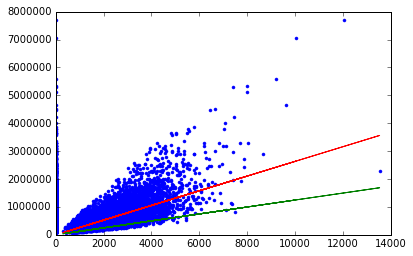

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'b.',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'r-',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'g-')

Look at each set of coefficients. If you were to plot ‘sqft_living’ vs the price, which of the two coefficients is the slope and which is the intercept? 
Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [95]:
def get_residual_sum_of_squares(predictions, outcome):
    # Then compute the residuals/errors
    residuals = predictions - outcome
    
    # Then square and add them up
    RSS = (residuals * residuals).sum()
    
    return(RSS)

In [96]:
# (simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)
## The initial weights (all zeros)
print initial_weights
simple_predictions1 = predict_output(simple_test_feature_matrix,  initial_weights) 
residuals1 = np.array(test_data['price'])  - simple_predictions1 
RSS1 = (residuals1*residuals1).sum()
print RSS1

[ 0.  0.]
1.78427328614e+15


In [97]:
## The weights learned with no regularization
print simple_weights_0_penalty
simple_predictions2 = predict_output(simple_test_feature_matrix, simple_weights_0_penalty) 
residuals2 = np.array(test_data['price'])  - simple_predictions2  
RSS2 = (residuals2*residuals2).sum()
print RSS2

[ -1.63113515e-01   2.63024369e+02]
2.75723632154e+14


In [98]:
## The weights learned with high regularization
print simple_weights_high_penalty
simple_predictions3 = predict_output(simple_test_feature_matrix, simple_weights_high_penalty) 
residuals3 = np.array(test_data['price'])  - simple_predictions3  
RSS3 = (residuals3*residuals3).sum()
print RSS3

[   9.76730382  124.57217567]
6.9464210149e+14


**QUIZ QUESTIONS**

**15. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization? **
263.0 for no regularlization, 124.6 for no regularlization

**16. Comparing the lines you fit with the with no regularization versus high regularization, which one is steeper?**
The fitted line we get with no regularlization is steeper, also seen from fact that itsa got higher slope term 263 vs 124   - no regularization

**17/18. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)?  **

Lowest RSS with no regularlization, the steeper curve is closer to more data points so lower RSS, lower bias.

# Running a multiple regression with L2 penalty

**19.** Let us now consider a model with 2 features: `['sqft_living', 'sqft_living15']`. First, create Numpy versions of your training and test data with these two features. 

In [99]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(train_feature_matrix, train_output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

get_numpy_data(): Features ['constant', 'sqft_living', 'sqft_living15'] 

get_numpy_data(): print features_pdframe(head(2)
   constant  sqft_living  sqft_living15
0         1       1180.0         1340.0
1         1       2570.0         1690.0 

get_numpy_data(): print features_pdframe.as_matrix()[0:2, :]
[[  1.00000000e+00   1.18000000e+03   1.34000000e+03]
 [  1.00000000e+00   2.57000000e+03   1.69000000e+03]] 

get_numpy_data(): data_pdframe['price']
0    221900.0
1    538000.0
Name: price, dtype: float64 

get_numpy_data(): data_pdframe['price'].as_matrix()
[ 221900.  538000.] 

get_numpy_data(): Features ['constant', 'sqft_living', 'sqft_living15'] 

get_numpy_data(): print features_pdframe(head(2)
   constant  sqft_living  sqft_living15
0         1       1430.0         1780.0
1         1       2950.0         2140.0 

get_numpy_data(): print features_pdframe.as_matrix()[0:2, :]
[[  1.00000000e+00   1.43000000e+03   1.78000000e+03]
 [  1.00000000e+00   2.95000000e+03   2.14000000e+0

**20.** First, let’s consider no regularization. Set the L2 penalty to 0.0 and run your ridge regression algorithm. Use the following parameters: We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [100]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

Call your weights:

`multiple_weights_0_penalty`

In [101]:
l2_penalty = 0.0
multiple_weights_0_penalty = ridge_regression_gradient_descent(train_feature_matrix, train_output, initial_weights, step_size, l2_penalty, max_iterations)
multiple_weights_0_penalty

array([  -0.35743483,  243.05416982,   22.41481497])

**22.** Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_high_penalty`

In [102]:
l2_penalty = 1e11 
multiple_weights_high_penalty = ridge_regression_gradient_descent(train_feature_matrix, train_output, initial_weights, step_size, l2_penalty, max_iterations)
multiple_weights_high_penalty

array([  6.74296579,  91.48927365,  78.43658766])

**23.** Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?  multiple_weights_0_penalty   - lowest RSS

**24. Quiz Question: What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)?**

In [103]:
# (simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)
## The initial weights (all zeros)
print initial_weights
predictions_test_data_initial = predict_output(test_feature_matrix,  initial_weights) 
residuals1 = test_output  - predictions_test_data_initial
RSS1 = (residuals1*residuals1).sum()
print RSS1
print("RSS weights learned with initial weights (all zeros): $%0.2f" % (RSS1))

[ 0.  0.  0.]
1.78427328614e+15
RSS weights learned with initial weights (all zeros): $1784273286136298.00


In [104]:
## The weights learned with no regularization
print multiple_weights_0_penalty 
predictions_test_data_0_penalty = predict_output(test_feature_matrix, multiple_weights_0_penalty) 
residuals2 = test_output  - predictions_test_data_0_penalty 
RSS2 = (residuals2*residuals2).sum()
print RSS2
print("RSS weights learned with initial weights (all zeros): $%.2f" % (RSS2))

[  -0.35743483  243.05416982   22.41481497]
2.74067615919e+14
RSS weights learned with initial weights (all zeros): $274067615918575.56


In [105]:
## The weights learned with high regularization
print multiple_weights_high_penalty
predictions_test_data_high_penalty = predict_output(test_feature_matrix, multiple_weights_high_penalty) 
residuals3 = test_output  - predictions_test_data_high_penalty  
RSS3 = (residuals3*residuals3).sum()
print RSS3
print("RSS weights learned with initial weights (all zeros): $%.2f" % (RSS3))

[  6.74296579  91.48927365  78.43658766]
5.00404800501e+14
RSS weights learned with initial weights (all zeros): $500404800500841.75


**25.** Predict the house price for the 1st house in the test set using the no regularization and high regularization models. (Remember that python starts indexing from 0.) How far is the prediction from the actual price?  Which weights perform best for the 1st house?  weights learned with high regularization perform better with 1st house.

In [106]:
print multiple_weights_0_penalty 
price_diff = abs( (test_data['price'][0] - predictions_test_data_0_penalty[0]))
print "Price Difference between predicted value = $%d and actual $%d is $%d" %(predictions_test_data_0_penalty[0], test_data['price'][0],price_diff  )
# print residuals2[0] == (test_data['price'][0] - predictions_test_data_0_penalty[0]) !!check TRUE

[  -0.35743483  243.05416982   22.41481497]
Price Difference between predicted value = $387465 and actual $310000 is $77465


In [107]:
print multiple_weights_high_penalty
price_diff = abs( (test_data['price'][0] - predictions_test_data_high_penalty[0]))
print "Price Difference between predicted value = $%d and actual $%d is $%d" %(predictions_test_data_high_penalty[0], test_data['price'][0],price_diff  )
# print residuals2[0] == (test_data['price'][0] - predictions_test_data_high_penalty[0]) !!check TRUE

[  6.74296579  91.48927365  78.43658766]
Price Difference between predicted value = $270453 and actual $310000 is $39546


***26. QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization? 
Answer: No Regularization: 243.0541689, High Regularization: 91.48927361

2. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 
Answer: initial: \$1.78427328252e+15, no regularization: \$2.74067618287e+14, high regularization: \$5.0040480058e+14

3. We make prediction for the first house in the test set using two sets of weights (no regularization vs high regularization). Which weights make better prediction <u>for that particular house</u>? weights learned with high regularization perform better with 1st house.

Answer: no regularization vs high regularization: price diff of \$77465 vs \$39546. Hence, high regularization gives better prediction, although we can also see that we get higher RSS with higher regularlization. This is because with no regularlization (lambda or l2_penalty =0.0), we just get the ordinary vanilla LS solution. 
```
Cost(w) = SUM[ (prediction - output)^2 ]               <---RSS term only
```
There is no cost imposed on overfitting, so we get some overfitting as the aim is just to minimise RSS, so we get lower RSS of $2.74067618287e+14, this is because overfitting leads to lower BIAS and RSS = BIAS + VAR**2.

Now when we impose a penalty to overfitting by increasing lambda l2_penalty to 1e11 from lambda=0, there is now higher cost for overfitting, due to ridge regularziation cost function.

Cost function is the sum over the data points of the squared difference between an observed output and a predicted output - our usual good old RSS term, plus the new L2 penalty term.
```
Cost(w) = SUM[ (prediction - output)^2 ]               <---RSS 
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2)          <---L2 penalty term 
```

Higher L2 (lambda) value forces the L2 norm `(w[0]^2 + w[1]^2 + ... + w[k]^2)` to be smaller, thus coefficients are shrunk, no surprise coefficient for `sqft_living` = 91.48 [compared to 243.05 when no regularlization]. This reduces overfitting, leading to lower VAR but also an increase in BIAS, so our RSS goes higher `$5.0040480058e+14` versus `$2.74067618287e+14` for no regularlization. But as we saw, we get better prediction accuracy due to decreased variance, and prediction accuracy is what counts in the end, not just RSS.